In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from tqdm import tqdm

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
text_data=open('seeds_dataset.txt').read()
text_data=text_data.split('\n')

df=pd.DataFrame(list(map(lambda x:x.split('\t'), text_data)))
df.drop(columns=[8,9],inplace=True)
df.shape

(210, 8)

In [4]:
df.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.871,5.763,3.312,2.221,5.22,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.905,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [5]:
df[7].value_counts()

1    70
2    70
3    70
Name: 7, dtype: int64

In [6]:
target=df[[7]].astype('int')

df.drop(columns=7,inplace=True)

scaler=StandardScaler()
df=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

In [7]:
dataset = list(zip(df.values, target.values))

In [8]:
train, test = train_test_split(dataset, test_size=0.1, random_state=SEED)
train, val = train_test_split(train, test_size=0.2, random_state=SEED)

len(train), len(val), len(test)

(151, 38, 21)

In [9]:
BATCH_SIZE = 8

train_iterator = data.DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)
val_iterator = data.DataLoader(val, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test, batch_size=BATCH_SIZE)

len(train_iterator), len(val_iterator), len(test_iterator) 

(19, 5, 3)

In [10]:
input_dim = 7
hidden_dim = 32
output_dim = 3

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        hidden = torch.sigmoid(self.fc1(x))
        output = torch.softmax(self.fc2(hidden), axis=1)
        
        return output
    
model = MLP(input_dim, hidden_dim, output_dim)

In [11]:
model

MLP(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

355

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
model = model.to(device)
criterion = criterion.to(device)

In [16]:
def calculate_accuracy(y_score, y):
    
    y_pred = torch.argmax(y_score, axis=1)
    
    return sum(y_pred == y) / len(y)

<code>optimizer.zero_grad()</code>

In PyTorch, we need to set the gradients to zero before model parameter update because **PyTorch accumulates gradients on subsequent backward passes by default**. The accumulation of gradients happen during the <code>loss.backward()</code> step.

<code>loss.backward()</code>
    
Calculating gradient for all parameters for which <code>requires_grad=True</code> and storing it in <code>parameter.grad</code>. This step is commonly called as **BackPropagation**.

<code>optimizer.step()</code>
    
Updating parameters with gradients calculated in the above step as per optimization algorithm (for example - in Gradient Descent, this would simply subtract the gradients in <code>parameter.grad</code> multiplied by learning rate). Learning Rate is considered as specified **while initializing optimizer**.

In [17]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0 
    epoch_acc = 0
    
    model.train()
    
    for x, y in iterator:

        optimizer.zero_grad()

        x=x.float().to(device)
        y=y.squeeze(dim=1).long().to(device)-1

        batch_size = x.shape[0]
        x = x.view(batch_size, -1).float()

        y_score = model(x)
        
        loss = criterion(y_score, y)
        acc = calculate_accuracy(y_score, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0 
    epoch_acc = 0
    
    model.eval()
    
    for x, y in iterator:

        x=x.float().to(device)
        y=y.squeeze(dim=1).long().to(device)-1

        batch_size = x.shape[0]
        x = x.view(batch_size, -1).float()

        y_score = model(x)
        
        loss = criterion(y_score, y)
        acc = calculate_accuracy(y_score, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
EPOCHS = 100

TRAIN_LOSS=[]
VAL_LOSS=[]

TRAIN_ACC=[]
VAL_ACC=[]

for epoch in tqdm(range(EPOCHS)):
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    
    val_loss, val_acc = evaluate(model, val_iterator, criterion, device)
    
    TRAIN_LOSS.append(train_loss)
    VAL_LOSS.append(val_loss)
    
    TRAIN_ACC.append(train_acc)
    VAL_ACC.append(val_acc)
    
print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}')
print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]

Train Loss: 0.586 | Train Acc: 0.974
Val Loss: 0.633 | Val Acc: 0.925


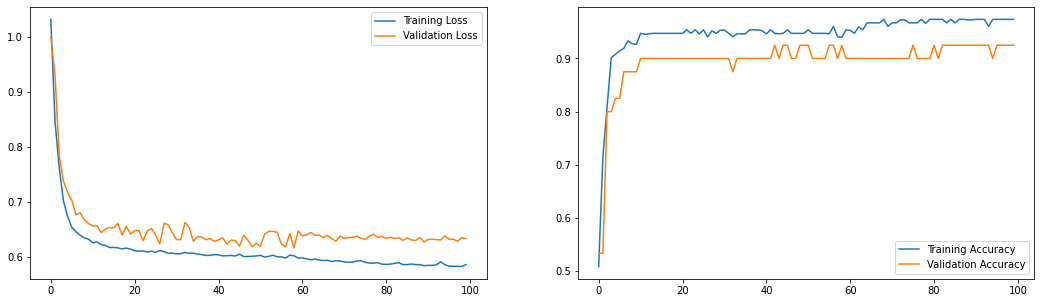

In [20]:
fig=plt.figure(figsize=(18,5))

plt.subplot(121)

plt.plot(TRAIN_LOSS, label='Training Loss')
plt.plot(VAL_LOSS, label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(TRAIN_ACC, label='Training Accuracy')
plt.plot(VAL_ACC, label='Validation Accuracy')
plt.legend()

plt.show()

In [21]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
test_acc

1.0